In [386]:
from glob import glob

import anndata
import numpy as np
import pandas as pd
import plotnine as p
from scipy import stats
import scvi
import torch
from torch.distributions import kl_divergence as kl
from torch.distributions import Normal
from torch.distributions import Poisson

%matplotlib inline

In [2]:
adata = anndata.read('Ren et al 2021/GSE158055_covid19_meta_S-M040-1_pbmcs.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 14565 × 27943
    obs: 'Meta sample', 'Sample name', 'title', 'organism', 'Patients', 'City', 'Age', 'Sex', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'SARS-CoV-2', 'Single cell sequencing platform', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G/L]', 'Neutrophils [G/L]', 'Lymphocytes [G/L]', 'Unpublished', 'geo accession', 'instrument model'

In [4]:
gene_panel = [
    'CLEC9A', 'CADM1', 'CLEC10A', 'CD1C', 'CD14', 'VCAN', 'CCR7', 'LAMP3', 'AXL', 'SIGLEC6', 'LILRA4', 'ITM2C',
    'GZMB', 'IL1B', 'IER3', 'LDLR', 'CD83', 'S100A12', 'CSF3R', 'FCGR3A', 'MS4A7', 'LILRB1', 'CSF1R',
    'CDKN1C', 'C1QA', 'C1QB', 'C1QC', 'CCR1', 'MARCO', 'MKI67', 'TOP2A',
    
    'CD141', 'CLEC9A', 'KIT', 'BTLA', 'CD1C', 'CD101', 'FCER1a', 'CD5', 'CD123', 'CD45RA', 'CD304', 'CD14',
    'CD99', 'CD64', 'CR1', 'ITGAM', 'CD16', 'C5AR1', 'CX3CR1',
    
    'NFKBIA', 'FOSB', 'IL1B', 'S100A8', 'S100A9', 'CD74', 'B2M', 'FTL', 'IL16', 'CCL2', 'CCL8', 'CCL7',
    'CCL4L2', 'CCL3', 'CCL4', 'CCL18', 'CXCL8', 'CXCL16', 'CXCL10',
    
    'TNF', 'IL6', 'IL12A', 'IL12B', 'IL23A', 'IL10', 'IL27',
    
    'TIMP1', 'GP9', 'MPIG6B', 'PF4', 'CLEC1B', 'RAP1B', 'SRGN', 'PPBP', 'STXBP2', 'PFN1',
    
    'CD34', 'AVP', 'CD38', 'GATA1', 'MPO',
    
    'CD3G', 'CCR7', 'CD27', 'CD4', 'CD28', 'TNFRSF9', 'CCR6', 'CD40LG', 'TBX21', 'GATA3', 'RORC', 'IKZF2',
    'FOXP3', 'CTLA4', 'PDCD1', 'CXCR5', 'CD8A', 'GZMB', 'HLA-DRB1', 'IFNG', 'LAG3', 'TOX', 'IL7R',
    'KLRG1', 'TRDV2', 'TRGV9', 'TRAV1.2', 'NCAM1', 'NCR1', 'FCGR3A',
    
    'CD3', 'CCR7', 'CD45RO', 'CD27', 'CD28', 'CD62L', 'CD25', 'CTLA4', 'CXCR5', 'CD40LG', 'ICOS', 'CXCR3',
    'CD8',
    
    'MS4A1', 'CD19', 'CD40', 'CD69', 'CD22', 'FCER2', 'CD24', 'CR2', 'MME', 'MKI67', 'IGHD', 'IGHM',
    'IGHA1', 'IGHG1', 'MZB1', 'CD27', 'TNFRSF13B', 'CD38', 'SDC1',
    
    'FOS', 'KLF2', 'PNRC1', 'NFKB1', 'JUN', 'DUSP1', 'FOSB', 'GADD45B', 'IER2', 'ZFP36', 'PPP1R15A',
    'NFKBIA', 'CD69', 'BTG2', 'CD79A', 'CD79B', 'PTPRC', 'LYIN', 'BLNK', 'SIGLEC10', 'PECAM1',
]

In [5]:
adata.var['feature_name'] = adata.var.index

var_idx = adata.var.query('feature_name in @gene_panel').index

fadata = adata[:, var_idx].copy()

In [6]:
fadata.obs['total_counts'] = np.array(fadata.X.sum(1))

In [7]:
fadata

AnnData object with n_obs × n_vars = 14565 × 141
    obs: 'Meta sample', 'Sample name', 'title', 'organism', 'Patients', 'City', 'Age', 'Sex', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'SARS-CoV-2', 'Single cell sequencing platform', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G/L]', 'Neutrophils [G/L]', 'Lymphocytes [G/L]', 'Unpublished', 'geo accession', 'instrument model', 'total_counts'
    var: 'feature_name'

In [9]:
scvi.model.SCVI.setup_anndata(fadata)

INFO      No batch_key inputted, assuming all cells are same batch                           
INFO      No label_key inputted, assuming all cells have same label                          
INFO      Using data from adata.X                                                            
INFO      Successfully registered anndata object containing 14565 cells, 141 vars, 1 batches,
          1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
          extra continuous covariates.                                                       
INFO      Please do not further modify adata until model is trained.                         


In [10]:
vae = scvi.model.SCVI(fadata, n_layers = 2, n_latent = 2, gene_likelihood = "poisson")

In [11]:
vae.train(max_epochs = 250, use_gpu = True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [04:26<00:00,  1.07s/it, loss=75.7, v_num=1]


In [152]:
fadata.obsm["X_scVI"] = vae.get_latent_representation()

for i, z in enumerate(fadata.obsm['X_scVI'].T):
    fadata.obs[f'Z_{i + 1}'] = z

In [375]:
# sindex = fadata.obs.query('Z_1 ** 2 + Z_2 ** 2 > 2 ** 2').sample(5).index

sindex = [
    'd13_PGW8_GATCGTACAAGAGTCG',
    'd13_PGW8_ATCACGACACCGTTGG',
    'd13_PGW8_GGTGAAGCAGTATCTG',
    'd13_PGW8_GACTACAAGCTAACTC',
    'd13_PGW8_AGGCCACCATTCTCAT'
]

sX = np.array(fadata[sindex].X.todense())
sobs = fadata.obs.loc[sindex]

fadata.obs['idx'] = fadata.obs.index

C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: fig1.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


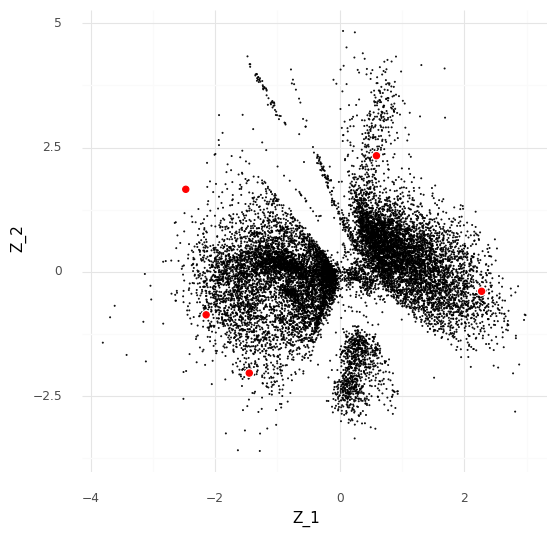

<ggplot: (-9223371934914050996)>


In [398]:
p.options.figure_size = 6, 6

p_ = (
    p.ggplot(p.aes(x = 'Z_1', y = 'Z_2'), fadata.obs)
    + p.geom_point(shape = '.', size = 0.1)
    + p.geom_point(shape = 'o', color = 'white', fill = None, size = 3, data = fadata.obs.query('idx in @sindex'))
    + p.geom_point(shape = 'o', color = 'red', fill = None, size = 2, data = fadata.obs.query('idx in @sindex'))
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 200)

print(p_)

In [382]:
btsfadatas = []
for i, n in enumerate(np.exp(np.linspace(np.log(1), np.log(500), 16)).round()):
    Xn = stats.binom.rvs(int(n), (sX.T / sobs['total_counts'].values).T)
    btsfadata = anndata.AnnData(X = Xn, obs = sobs, var = fadata.var)
    btsfadata.obs['thinning'] = n
    btsfadata.obs['idx'] = sobs.index
    btsfadata.obs.index = sobs.index + f'_{i}'
    btsfadatas += [btsfadata]
    
btadata = anndata.concat(btsfadatas)

C:\Users\vale\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: X.dtype being converted to np.float32 from int32. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  after removing the cwd from sys.path.


In [383]:
btadata.obsm["X_scVI"] = vae.get_latent_representation(adata = btadata)

for i, z in enumerate(btadata.obsm['X_scVI'].T):
    btadata.obs[f'Z_{i + 1}'] = z

INFO      Input adata not setup with scvi. attempting to transfer anndata setup              
INFO      Using data from adata.X                                                            
INFO      Registered keys:['X', 'batch_indices', 'labels']                                   
INFO      Successfully registered anndata object containing 80 cells, 141 vars, 1 batches, 1 
          labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra 
          continuous covariates.                                                             


C:\Users\vale\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: fig2.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
C:\Users\vale\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
C:\Users\vale\Anaconda3\lib\site-packages\pandas\core\arraylike.p

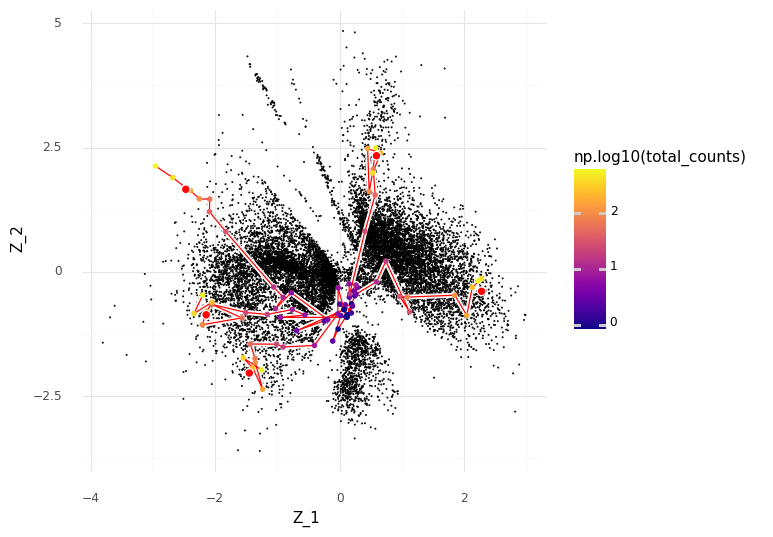

<ggplot: (-9223371934899603592)>


In [405]:
p.options.figure_size = 6, 6

p_ = (
    p.ggplot(p.aes(x = 'Z_1', y = 'Z_2'), fadata.obs)
    + p.geom_point(shape = '.', size = 0.1)
    + p.geom_path(p.aes(group = 'idx'), color = 'white', size = 2, data = btadata.obs)
    + p.geom_path(p.aes(group = 'idx'), color = 'red', data = btadata.obs)
    + p.geom_point(p.aes(color = 'np.log10(total_counts)'), shape = '.', size = 3.0, data = btadata.obs)
    + p.geom_point(shape = 'o', color = 'white', fill = None, size = 3, data = fadata.obs.query('idx in @sindex'))
    + p.geom_point(shape = 'o', color = 'red', fill = None, size = 2, data = fadata.obs.query('idx in @sindex'))
    + p.scale_color_continuous('plasma')
    + p.theme_minimal()
)

p_.save('fig2.png', dpi = 200)

print(p_)

In [388]:
tmp_adata_ = vae._validate_anndata(btadata)
scdl_ = vae._make_data_loader(tmp_adata_)

for tensors in scdl_:
    tmp_ = vae.module(tensors)
    
pz = Normal(torch.zeros_like(tmp_[0]['qz_m']), torch.ones_like(tmp_[0]['qz_m']))
qz = Normal(tmp_[0]['qz_m'], tmp_[0]['qz_v'])

In [389]:
btadata.obs['total_counts'] = np.array(btadata.X.sum(1))
btadata.obs['log_prob'] = Poisson(tmp_[1]['px_rate'].cpu()).log_prob(tensors['X']).sum(1).detach().numpy()
btadata.obs['m_log_prob'] = -btadata.obs['log_prob']
btadata.obs['kl'] = kl(qz, pz).sum(1).cpu().detach().numpy()

C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: fig3.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


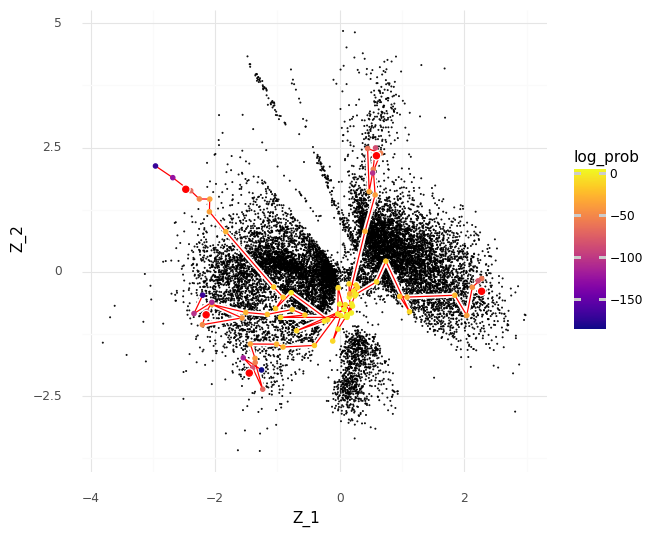

<ggplot: (-9223371934899362632)>


In [406]:
p.options.figure_size = 6, 6

p_ = (
    p.ggplot(p.aes(x = 'Z_1', y = 'Z_2'), fadata.obs)
    + p.geom_point(shape = '.', size = 0.1)
    + p.geom_path(p.aes(group = 'idx'), color = 'white', size = 2, data = btadata.obs)
    + p.geom_path(p.aes(group = 'idx'), color = 'red', data = btadata.obs)
    + p.geom_point(p.aes(color = 'log_prob'), shape = '.', size = 3.0, data = btadata.obs)
    + p.geom_point(shape = 'o', color = 'white', fill = None, size = 3, data = fadata.obs.query('idx in @sindex'))
    + p.geom_point(shape = 'o', color = 'red', fill = None, size = 2, data = fadata.obs.query('idx in @sindex'))
    + p.scale_color_continuous('plasma')
    + p.theme_minimal()
)

p_.save('fig3.png', dpi = 200)

print(p_)

C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: fig4.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


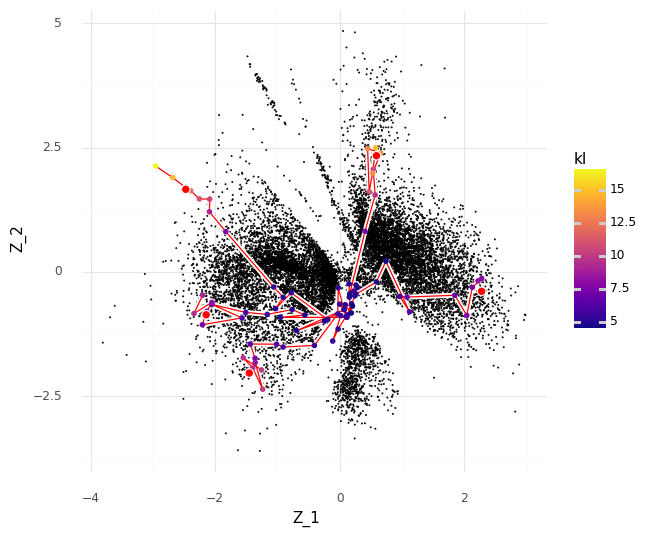

<ggplot: (-9223371934898121792)>


In [407]:
p.options.figure_size = 6, 6

p_ = (
    p.ggplot(p.aes(x = 'Z_1', y = 'Z_2'), fadata.obs)
    + p.geom_point(shape = '.', size = 0.1)
    + p.geom_path(p.aes(group = 'idx'), color = 'white', size = 2, data = btadata.obs)
    + p.geom_path(p.aes(group = 'idx'), color = 'red', data = btadata.obs)
    + p.geom_point(p.aes(color = 'kl'), shape = '.', size = 3.0, data = btadata.obs)
    + p.geom_point(shape = 'o', color = 'white', fill = None, size = 3, data = fadata.obs.query('idx in @sindex'))
    + p.geom_point(shape = 'o', color = 'red', fill = None, size = 2, data = fadata.obs.query('idx in @sindex'))
    + p.scale_color_continuous('plasma')
    + p.theme_minimal()
)

p_.save('fig4.png', dpi = 200)

print(p_)

C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: fig5.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
C:\Users\vale\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\vale\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
C:\Users\vale\Anaconda3\lib\site-packages\pandas\core\arraylike.p

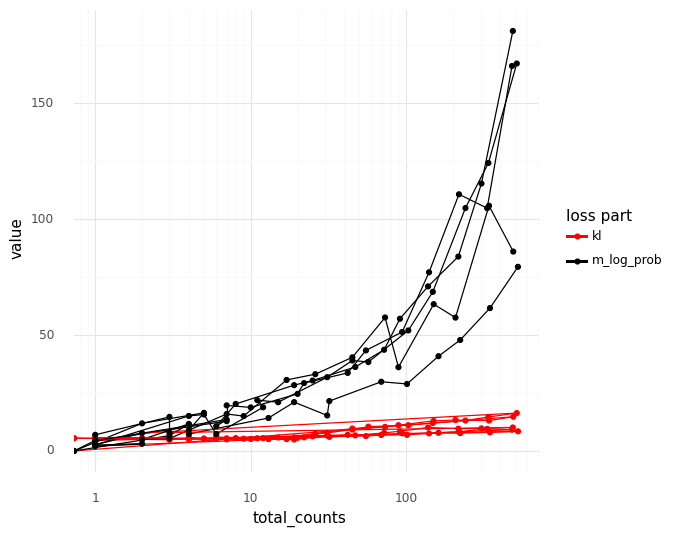

<ggplot: (-9223371934899375732)>


In [408]:
tmp_df_ = btadata.obs.melt(
    value_vars = ['kl', 'm_log_prob'],
    id_vars = ['thinning', 'total_counts', 'idx'],
    var_name = 'loss part'
)

p.options.figure_size = 6, 6

p_ = (
    p.ggplot(p.aes(x = 'total_counts', y = 'value', color = 'loss part', group = 'idx'), tmp_df_)
    + p.geom_path()
    + p.geom_point()
    + p.scale_color_manual({'kl': 'red', 'm_log_prob': 'k'})
    + p.scale_x_log10()
    + p.theme_minimal()
)

p_.save('fig5.png', dpi = 200)

print(p_)

In [431]:
torch.lgamma(1 + torch.from_numpy(np.arange(0, 10)))

tensor([ 0.0000,  0.0000,  0.6931,  1.7918,  3.1781,  4.7875,  6.5793,  8.5252,
        10.6046, 12.8018])

In [425]:
x = np.linspace(0, 5)
x ** 2 - np.log(x)

C:\Users\vale\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


array([        inf,  2.29279471,  1.63088452,  1.27748105,  1.06268528,
        0.93325268,  0.86546673,  0.84667632,  0.86932985,  0.92855639,
        1.02103011,  1.14437882,  1.296851  ,  1.47711649,  1.68414138,
        1.91710603,  2.17534968,  2.45833189,  2.76560496,  3.09679389,
        3.45158139,  3.82969668,  4.23090678,  4.65500979,  5.1018296 ,
        5.57121168,  6.06301971,  6.57713277,  7.11344318,  7.67185457,
        8.25228038,  8.85464258,  9.47887056, 10.12490023, 10.79267326,
       11.48213637, 12.19324079, 12.92594177, 13.68019814, 14.45597193,
       15.25322805, 16.07193402, 16.91205971, 17.77357711, 18.65646014,
       19.56068449, 20.48622745, 21.43306777, 22.40118554, 23.39056209])

In [427]:
1 / np.sqrt(2)

0.7071067811865475

In [432]:
1 / 2 - np.log(1 / np.sqrt(2)) - 1 / 2

0.3465735902799727

In [313]:
vae_untrained = scvi.model.SCVI(fadata, n_layers = 2, n_latent = 2, gene_likelihood = "poisson")

In [318]:
tmp_adata_ = vae_untrained._validate_anndata(btadata)
scdl_ = vae_untrained._make_data_loader(tmp_adata_)

In [342]:

for tensors in scdl_:
    tmp_ = vae_untrained.module(tensors)

In [326]:
-Poisson(tmp_[1]['px_rate'].cpu()).log_prob(tensors['X']).sum(1)

tensor([   6.0440,   -0.0000,   10.5798,   -0.0000,    6.2032,   -0.0000,
           5.9552,    6.0723,   23.0142,   10.3024,   15.8123,   19.0770,
          15.6168,   11.0855,    6.0289,   21.8033,   25.6812,   -0.0000,
          10.6467,   18.7336,   19.3356,   15.1664,   23.0493,   20.3318,
          23.2870,   25.8693,   43.2900,   36.4248,   44.5156,   20.8490,
          57.1529,   26.9210,   45.0243,   42.7470,   63.9227,   75.4784,
          51.3214,   55.5843,   83.1422,   63.4543,  102.3100,   88.4346,
          86.7331,   86.8842,  124.2706,  110.9633,  141.7215,  156.5460,
         173.4534,  168.0140,  164.4944,  235.1983,  185.2806,  204.9372,
         206.5901,  271.8311,  312.0688,  293.0325,  313.5493,  380.0880,
         478.9369,  471.2493,  482.7967,  475.3489,  542.4332,  667.7817,
         738.0413,  590.0165,  705.3427,  814.3356, 1098.9780, 1048.2201,
         905.9785,  982.9564, 1157.5858, 1551.1549, 1539.4226, 1306.9302,
        1597.8823, 1708.9341], grad_fn

In [327]:
pz = Normal(torch.zeros_like(tmp_[0]['qz_m']), torch.ones_like(tmp_[0]['qz_m']))
qz = Normal(tmp_[0]['qz_m'], tmp_[0]['qz_v'])

In [328]:
kl(qz, pz).sum(1)

tensor([0.6661, 0.1206, 0.2088, 0.5755, 0.5074, 0.5104, 0.5456, 0.2000, 0.3141,
        0.2727, 0.3260, 0.2654, 0.5096, 0.7445, 0.2465, 0.2199, 0.1484, 0.6198,
        0.1347, 0.3030, 0.1338, 0.1534, 0.2256, 0.0219, 0.9259, 0.2997, 0.4125,
        0.0696, 0.0907, 0.6820, 0.1046, 0.1770, 0.4751, 0.1644, 1.7753, 0.1969,
        0.3616, 0.2274, 0.3419, 0.8217, 0.3760, 0.7810, 0.7028, 0.0678, 1.3196,
        0.2678, 1.4237, 0.3444, 0.1926, 0.5801, 0.2322, 0.5507, 2.5338, 0.1000,
        2.4724, 0.1161, 0.3583, 0.9324, 0.5184, 0.7447, 0.3589, 0.0446, 2.0150,
        0.6673, 1.0204, 0.6945, 0.8642, 2.2390, 0.8370, 0.9521, 0.9257, 2.7713,
        4.4485, 0.7167, 1.1257, 0.3516, 0.7415, 3.8781, 0.7742, 1.2627],
       grad_fn=<SumBackward1>)